In [14]:
import tensorflow as tf
import tensorflow.keras as keras
# This doesn't even matter because Aurelien is an idiot
import tensorflow_datasets as tfds

In [15]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 139s 0us/step


In [18]:
from pathlib import Path
# getting all the paths for the TFRecords we just downloaded from tensorflow's data API
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [20]:
# Sanity Check
train_files

['/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/ryuparish/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [23]:
# Getting all the classes from the text files containing the classes of both the training set and the
# testing set (they are the exact same classes)
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [24]:
# Sanity Check
# Unstripped
train_classes

['garden hose\n',
 'lighter\n',
 'penguin\n',
 'tractor\n',
 'sheep\n',
 'skateboard\n',
 'mountain\n',
 'mouse\n',
 'chandelier\n',
 'guitar\n',
 'roller coaster\n',
 'owl\n',
 'toilet\n',
 'map\n',
 'snail\n',
 'yoga\n',
 'spoon\n',
 'camera\n',
 'telephone\n',
 'bench\n',
 'pig\n',
 'lion\n',
 'skull\n',
 'hand\n',
 'raccoon\n',
 'beard\n',
 'church\n',
 'animal migration\n',
 'whale\n',
 'sun\n',
 'washing machine\n',
 'airplane\n',
 'megaphone\n',
 'sleeping bag\n',
 'jail\n',
 'fire hydrant\n',
 'car\n',
 'barn\n',
 'swing set\n',
 'rake\n',
 'paintbrush\n',
 'van\n',
 'dragon\n',
 'sailboat\n',
 'compass\n',
 'duck\n',
 'hat\n',
 'kangaroo\n',
 'donut\n',
 'crocodile\n',
 'coffee cup\n',
 'cooler\n',
 'waterslide\n',
 'feather\n',
 'firetruck\n',
 'stereo\n',
 'leg\n',
 'tree\n',
 'pillow\n',
 'purse\n',
 'hourglass\n',
 'ear\n',
 'broccoli\n',
 'goatee\n',
 'moon\n',
 'bridge\n',
 'peas\n',
 'squiggle\n',
 'foot\n',
 'camouflage\n',
 'string bean\n',
 'pants\n',
 'lipstick\n',


In [26]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]
# Stripped
class_names

['garden hose',
 'lighter',
 'penguin',
 'tractor',
 'sheep',
 'skateboard',
 'mountain',
 'mouse',
 'chandelier',
 'guitar',
 'roller coaster',
 'owl',
 'toilet',
 'map',
 'snail',
 'yoga',
 'spoon',
 'camera',
 'telephone',
 'bench',
 'pig',
 'lion',
 'skull',
 'hand',
 'raccoon',
 'beard',
 'church',
 'animal migration',
 'whale',
 'sun',
 'washing machine',
 'airplane',
 'megaphone',
 'sleeping bag',
 'jail',
 'fire hydrant',
 'car',
 'barn',
 'swing set',
 'rake',
 'paintbrush',
 'van',
 'dragon',
 'sailboat',
 'compass',
 'duck',
 'hat',
 'kangaroo',
 'donut',
 'crocodile',
 'coffee cup',
 'cooler',
 'waterslide',
 'feather',
 'firetruck',
 'stereo',
 'leg',
 'tree',
 'pillow',
 'purse',
 'hourglass',
 'ear',
 'broccoli',
 'goatee',
 'moon',
 'bridge',
 'peas',
 'squiggle',
 'foot',
 'camouflage',
 'string bean',
 'pants',
 'lipstick',
 'jacket',
 'hockey puck',
 'truck',
 'table',
 'hammer',
 'the great wall of china',
 'paint can',
 'fireplace',
 'leaf',
 'apple',
 'beach',
 'w

In [27]:
# Parser for the TFRecords stored (Protobufs)
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [31]:
# The function that actually 
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    # Reading from n_read_threads number of threads, interleaving the them one after another until it runs out
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [32]:
# At Train and Test time, the datasets will read from their files efficiently
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [33]:
for strokes, lengths, labels in train_set.take(1):
    # The strokes are continuous screen touches, from the origin [0,0].
    # The third value in the stroke determines if the stroke ended with that stroke, otherwise,
    # the stroke after continues off of the last point that was unfinished
    print("strokes =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.02362205  0.09302327  0.        ]
  [ 0.00393701  0.10465118  0.        ]
  [ 0.03937008  0.12209302  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.01968504  0.04807692  0.        ]
  [ 0.08661418  0.08653846  0.        ]
  [ 0.1535433   0.03846154  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.07258064  0.1764706   0.        ]
  [-0.13306452  0.63529414  0.        ]
  [ 0.40725806  0.06666666  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.17989421  0.          0.        ]
  [-0.1111111   0.04313725  0.        ]
  [-0.06349206  0.05490196  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

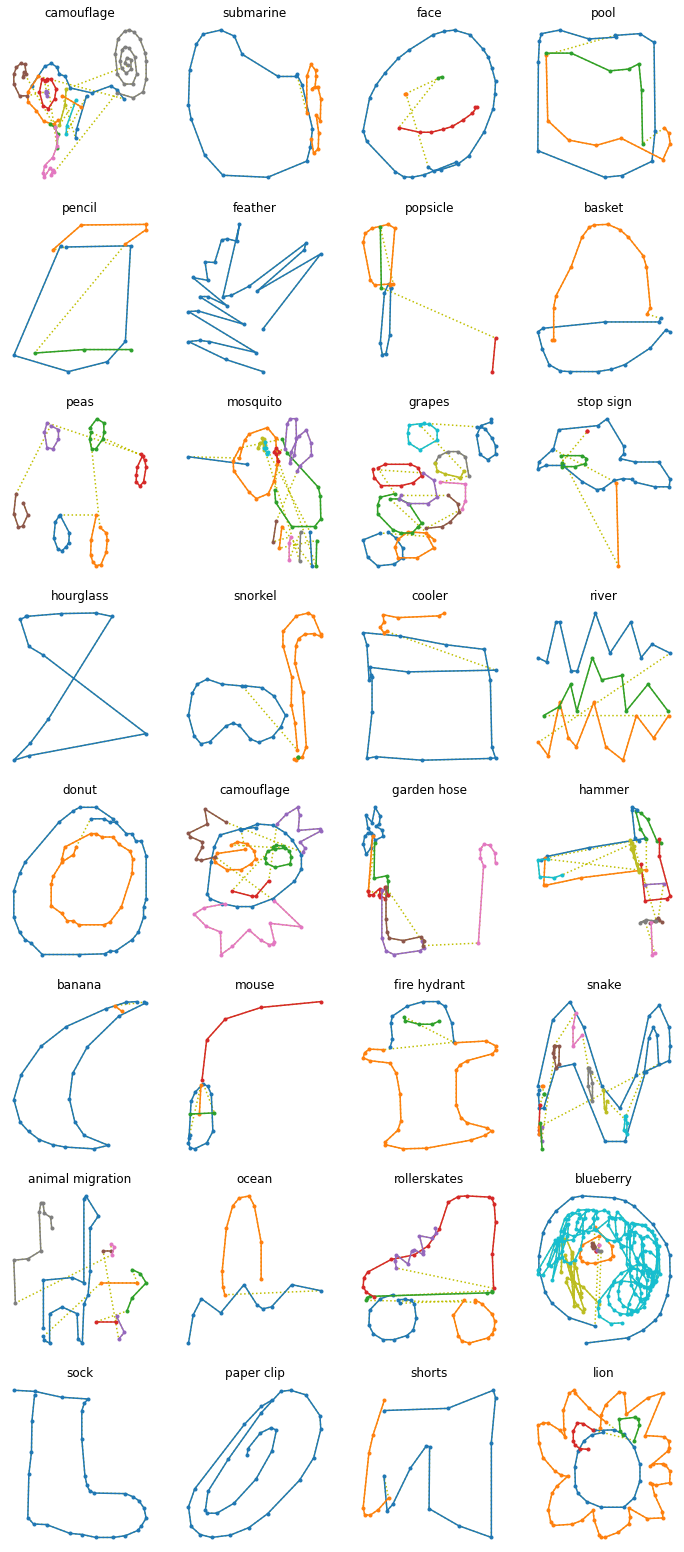

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

# This is matplotlib's configuration to display the drawings
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

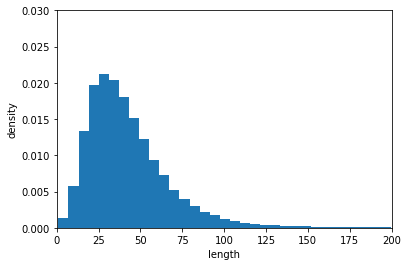

In [39]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [40]:
# Cropping off the sketches that have more than 100 points for ?brevity?
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

/home/ryuparish/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2
   6897/Unknown - 85s 12ms/step - loss: 5.7103 - accuracy: 0.0070 - sparse_top_k_categorical_accuracy: 0.0324

KeyboardInterrupt: 